## **Imports**

In [48]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
import joblib
import os
import datetime
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
RANDOM_SEED = 42

## **1. Data Loading**
- This function, `load_and_preprocess_data`, is responsible for loading the dataset, sorting it by date to preserve the time-series nature of the data, and encoding team names by identifying unique teams common to both Home and Away teams.

In [49]:
# Function: Load and preprocess data
def load_and_preprocess_data(filepath, save_encoder_path=None):
    df = pd.read_csv(filepath)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)

    unique_teams = pd.unique(df[['HomeTeam', 'AwayTeam']].values.ravel())
    team_encoder = LabelEncoder()
    team_encoder.fit(unique_teams)
    df["HomeTeam_enc"] = team_encoder.transform(df["HomeTeam"])
    df["AwayTeam_enc"] = team_encoder.transform(df["AwayTeam"])

    target = 'FTR'
    features = list(dict.fromkeys(['HomeTeam_enc', 'AwayTeam_enc'] + 
                              list(df.drop(columns=[target, 'Date', 'HomeTeam', 'AwayTeam']).columns)))

    X = df[features]
    y = df[target]

    # Save the team encoder if a path is provided
    if save_encoder_path:
        joblib.dump(team_encoder, save_encoder_path)
        print(f"[INFO] Saved team encoder to {save_encoder_path}")
    
    # Sanity check
    print("\n[INFO] Loaded dataset shape:", df.shape)
    print("[INFO] Feature columns:", features)
    print("[INFO] Target distribution:\n", y.value_counts())
    return df, X, y, team_encoder

## **2. Target Encoding**
- This function transforms the target variable `FTR` from three classes (H/D/A) into a binary format. It assigns a value of `1` if the result is a Home win (`H`), and `0` for Draws (`D`) or Away wins (`A`). This binary target is useful for simplifying the classification problem into two classes: Home wins vs. Home loses.

In [50]:
# Function: Create binary target variable (H vs. not H)
def create_binary_target(df, target_col='FTR'):
    """
    Transform the target variable from three classes (H/D/A) to binary (H/Home loses)
    
    Args:
        df: DataFrame containing the target column
        target_col: Name of the target column
        
    Returns:
        Series with binary target values:
        - 1: Home team wins (H)
        - 0: Home team loses (D or A)
    """
    # Create a copy of the original target
    df = df.copy()
    
    # Create binary target (1 for Home win, 0 for Draw or Away win)
    df[f'{target_col}_binary'] = df[target_col].apply(lambda x: 1 if x == 'H' else 0)
    
    # Print distribution of the new target
    print(f"\n[INFO] Binary target distribution:")
    binary_distribution = df[f'{target_col}_binary'].value_counts()
    print(f"Home wins (1): {binary_distribution.get(1, 0)}")
    print(f"Home loses (0): {binary_distribution.get(0, 0)}")
    
    return df[f'{target_col}_binary']

## **3. Time-Series Split Function**
- This function ensures the temporal integrity of the dataset by sorting it by date and splitting it into training and testing sets based on a specified test size. This approach is crucial for time-series data to prevent data leakage from future observations into the training set.

In [51]:
# Function: Time series split
def time_series_split(df, test_size=0.2):
    df = df.sort_values('Date')
    split_idx = int(len(df) * (1 - test_size))
    return df.iloc[:split_idx], df.iloc[split_idx:]

## **4. Flexible Label Encoder**

- This Function handles label encoding for both binary and multi-class targets.
- Steps:
    - If the target is binary, return the values as-is (no encoding needed).
    - If the target is multi-class, use `LabelEncoder` to encode the labels.

In [52]:
# Encode_labels function that handles both original and binary targets
def encode_labels_flexible(y_train, y_test, is_binary=False):
    """
    Encodes target labels, with special handling for binary targets
    
    Args:
        y_train: Training target data
        y_test: Test target data
        is_binary: Whether the target is already binary (0/1)
        
    Returns:
        Encoded y_train, y_test, and the label encoder
    """
    if is_binary:
        # For binary targets that are already 0/1, no need for label encoding
        print("\n[INFO] Using binary target (Home win vs. Home loses)")
        print("[INFO] Encoded classes: [0: Home loses, 1: Home wins]")
        return y_train.values, y_test.values, None
    else:
        # For original 3-class target, use LabelEncoder
        label_encoder = LabelEncoder()
        y_train_enc = label_encoder.fit_transform(y_train)
        y_test_enc = label_encoder.transform(y_test)
        print("\n[INFO] Using original target (H/D/A)")
        print("[INFO] Encoded classes:", label_encoder.classes_)
        return y_train_enc, y_test_enc, label_encoder

## **5. Model Setup With Hyperparameters**
- This function defines machine learning models and their hyperparameters.

In [53]:
# Function: Build models
def build_models():
    """
    Build a dictionary of models with their respective pipelines and hyperparameters.
    Return a dictionary of models with their configurations
    """
    return {
        'LogisticRegression': {
            'model': Pipeline([
                ("scaler", StandardScaler()),
                ("clf", LogisticRegression(max_iter=5000, random_state=RANDOM_SEED, penalty='l2', C=1.0))
            ]),
            'params': {
                'clf__C': [0.1, 1.0, 10.0]
            }
        },
        'RandomForest': {
            'model': RandomForestClassifier(class_weight='balanced', random_state=RANDOM_SEED),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [10, 20],
                'min_samples_split': [5, 10]
            }
        },
        'SVM': {
            'model': Pipeline([
                ("scaler", StandardScaler()),
                ("clf", SVC(kernel="rbf", probability=True, random_state=RANDOM_SEED))
            ]),
            'params': {
                'clf__C': [0.1, 1.0, 10.0],
                'clf__gamma': [0.01, 0.1, 1.0]
            }
        },
        'XGBoost': {
            'model': XGBClassifier(eval_metric='mlogloss', random_state=RANDOM_SEED, verbosity=2),
            'params': {
                'learning_rate': [0.05, 0.1],
                'max_depth': [6, 8],
                'subsample': [0.8, 1.0]
            }
        },
        'LightGBM': {
            'model': LGBMClassifier(random_state=RANDOM_SEED),
            'params': {
                'num_leaves': [31, 63],
                'learning_rate': [0.05, 0.1],
                'n_estimators': [100, 200],
                'verbose': [-1],
            }
        }
    }

## **6. Training With Cross-Validation**
- This function trains and tune models using cross-validation. The process involves using TimeSeriesSplit for temporal data splitting, GridSearchCV for hyperparameter tuning, and adjusting the scoring metric based on the classification task (binary or multi-class). The function returns the best model and it's cross-validation results.

In [54]:
# Function: Train and tune models
def train_and_tune_models(models, xtrain, ytrain, scoring='roc_auc_ovr'):
    best_models = {}
    cv_results = []
    
    # Adjust scoring metric based on whether it's binary or multi-class
    if len(np.unique(ytrain)) == 2:
        actual_scoring = 'roc_auc'  # Binary classification
    else:
        actual_scoring = 'roc_auc_ovr'  # Multi-class classification
    
    print(f"\n[INFO] Using {actual_scoring} for model evaluation")

    for name, config in models.items():
        print(f"\n=== Tuning {name} ===")
        try:
            tscv = TimeSeriesSplit(n_splits=3)
            gs = GridSearchCV(
                              config['model'], 
                              config['params'], 
                              cv=tscv, 
                              scoring=actual_scoring,
                              n_jobs=-1, 
                              error_score='raise'
                            )
            gs.fit(xtrain, np.ravel(ytrain))

            print(f"[INFO] Best params for {name}: {gs.best_params_}")
            best_models[name] = gs.best_estimator_
            cv_results.append({
                'model': name,
                'best_score': gs.best_score_,
                'best_params': gs.best_params_
            })
        except Exception as e:
            print(f"[ERROR] Failed to train {name}: {e}")

    return best_models, cv_results

## **7. Evaluation & Visualization**
- This function evaluates model performances and visualize results by comparing metrics across models using bar plots and plotting confusion matrix for the best model.

In [55]:
# Function: Evaluate and visualize results
def evaluate_and_visualize(best_models, xtest, ytest, feature_names, label_encoder=None, is_binary=False):
    final_results = []
    best_model_name = None
    best_model_metrics = None
    highest_accuracy = 0

    for name, model in best_models.items():
        print(f"\n=== Evaluating {name} ===")

        ypred = model.predict(xtest)
        yproba = model.predict_proba(xtest)

        accuracy = accuracy_score(ytest, ypred)
        
        # Handle ROC AUC calculation based on problem type
        if is_binary:
            roc_auc = roc_auc_score(ytest, yproba[:, 1])  # For binary, use probability of positive class
        else:
            roc_auc = roc_auc_score(ytest, yproba, multi_class='ovr')  # For multi-class

        precision = precision_score(ytest, ypred, average='weighted', zero_division=0)
        recall = recall_score(ytest, ypred, average='weighted')
        f1 = f1_score(ytest, ypred, average='weighted')

        metrics = {
            'model': name,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        final_results.append(metrics)

        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            best_model_name = name
            best_model_metrics = {'ypred': ypred, 'model_name': name}

        print(f"Accuracy: {accuracy:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

    print(f"\n=== Confusion Matrix for Best Model: {best_model_name} ===")
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(ytest, best_model_metrics['ypred'])
    
    # Set labels based on problem type
    if is_binary:
        labels = ['Home loses', 'Home wins']
    else:
        labels = label_encoder.classes_
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels,
                yticklabels=labels)
    
    plt.title(f'Confusion Matrix - {best_model_metrics["model_name"]}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    
    # Define the directory to save the image
    image_dir = "/Users/fitsumbahlebi/Desktop/repo2/PremierLeagueMatchPredictor/Images"
    os.makedirs(image_dir, exist_ok=True)  # Create the directory if it doesn't exist
    
    # Save the confusion matrix image
    suffix = "_binary" if is_binary else "_multiclass"
    confusion_matrix_path = os.path.join(image_dir, f'{best_model_name}_confusion_matrix{suffix}.png')
    plt.savefig(confusion_matrix_path)
    print(f"[INFO] Saved confusion matrix to {confusion_matrix_path}")
    plt.show()

    results_df = pd.DataFrame(final_results)
    metrics_to_plot = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1_score']
    results_df_melted = results_df.melt(id_vars='model', value_vars=metrics_to_plot, 
                                        var_name='Metric', value_name='Score')

    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df_melted, x='Metric', y='Score', hue='model', palette='Set2')
    
    # Add suffix to title based on problem type
    title_suffix = "Binary Classification (H vs. Home loses)" if is_binary else "Multi-class Classification (H/D/A)"
    plt.title(f'Performance Metrics for All Models - {title_suffix}')
    
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Save the performance metrics image
    performance_metrics_path = os.path.join(image_dir, f'model_performance_metrics{suffix}.png')
    plt.savefig(performance_metrics_path)
    print(f"[INFO] Saved performance metrics to {performance_metrics_path}")
    plt.show()

    return final_results

## **8. Result Comparison**
- This function compares model results and save them to a CSV file.  
  

In [56]:
def compare_results(final_results, output_dir, suffix=""):
    """
    Compare model results, save sorted results to CSV, and return the DataFrame.
    
    Args:
        final_results: List of dictionaries containing model metrics
        output_dir: Directory to save the results
        suffix: String to append to the filename
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create and sort DataFrame
    results_df = pd.DataFrame(final_results).sort_values('roc_auc', ascending=False)
    
    # Display results
    print(f"\nFinal Model Comparison ({suffix}):")
    print(results_df[['model', 'accuracy', 'roc_auc']])
    
    # Save to CSV in the specified directory
    csv_path = os.path.join(output_dir, f'final_model_results_{suffix}.csv')
    results_df.to_csv(csv_path, index=False)
    print(f"[INFO] Saved sorted results to {csv_path}")
    
    return results_df

## **9. Compare binary vs multiclass performance**
- The function `compare_binary_vs_multiclass` compares the performance of binary and multi-class classification approaches. It extract the best model from each approach and creates a comparison DataFrame with metrics such as accuracy, ROC AUC, and F1 score. Finally, it visualizes the comparison using bar plots to highlight differences in performance.



In [57]:
# Function: Compare binary vs multiclass performance
def compare_binary_vs_multiclass(multiclass_results, binary_results):
    print("\n=== Comparison: Binary vs. Multiclass ===")
    
    # Get best model from each approach
    best_multiclass = multiclass_results.iloc[0].to_dict()
    best_binary = binary_results.iloc[0].to_dict()
    
    comparison = pd.DataFrame({
        'Approach': ['Multiclass (H/D/A)', 'Binary (H vs. Home loses)'],
        'Best Model': [best_multiclass['model'], best_binary['model']],
        'Accuracy': [best_multiclass['accuracy'], best_binary['accuracy']],
        'ROC AUC': [best_multiclass['roc_auc'], best_binary['roc_auc']],
        'F1 Score': [best_multiclass['f1_score'], best_binary['f1_score']]
    })
    
    print(comparison)
    
    # Visualize comparison
    plt.figure(figsize=(10, 6))
    comparison_melted = comparison.melt(id_vars=['Approach', 'Best Model'], 
                                        value_vars=['Accuracy', 'ROC AUC', 'F1 Score'],
                                        var_name='Metric', value_name='Score')
    
    sns.barplot(data=comparison_melted, x='Metric', y='Score', hue='Approach', palette=['skyblue', 'coral'])
    plt.title('Comparison: Binary vs. Multiclass Classification')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.legend(title='Approach')
    plt.tight_layout()
    
    # Define the directory to save the image
    image_dir = "/Users/fitsumbahlebi/Desktop/repo2/PremierLeagueMatchPredictor/Images"
    os.makedirs(image_dir, exist_ok=True)  # Create the directory if it doesn't exist
    
    # Save the image to the specified directory
    image_path = os.path.join(image_dir, 'binary_vs_multiclass_comparison.png')
    plt.savefig(image_path)
    print(f"[INFO] Saved comparison plot to {image_path}")
    
    plt.show()
    
    return comparison

## **10. Main Execution Block**
- The function `run_epl_prediction` is the Main function to execute the entire pipeline

In [58]:
def run_epl_prediction(csv_path, run_original=True, run_binary=True, save_models=True):
    """
    Run the EPL match prediction pipeline with options for original and binary target
    
    Args:
        csv_path: Path to the CSV data file
        run_original: Whether to run the original 3-class model (H/D/A)
        run_binary: Whether to run the binary model (H vs. Home loses)
        save_models: Whether to save the best models and encoders
    """
    results = {}
    
    # Define output directories
    base_dir = "/Users/fitsumbahlebi/Desktop/repo2/PremierLeagueMatchPredictor"
    model_dir = os.path.join(base_dir, "Model")
    results_dir = os.path.join(base_dir, "Results")
    
    # Create directories if they don't exist
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)
    
    # Load data
    # Filepath to save the team encoder
    encoder_save_path = os.path.join(model_dir, "team_encoder.pkl")
    df, X, y, team_encoder = load_and_preprocess_data(csv_path, save_encoder_path=encoder_save_path)
    
    # Create binary target if needed
    if run_binary:
        y_binary = create_binary_target(df)
    
    # Split data
    train_df, test_df = time_series_split(df, test_size=0.2)
    xtrain = X.loc[train_df.index]
    xtest = X.loc[test_df.index]
    
    # Original multi-class approach (H/D/A)
    if run_original:
        print("\n" + "="*50)
        print("Running Original Multi-class Model (H/D/A)")
        print("="*50)
        
        ytrain = y.loc[train_df.index]
        ytest = y.loc[test_df.index]
        
        ytrain_enc, ytest_enc, label_encoder = encode_labels_flexible(ytrain, ytest, is_binary=False)
        models = build_models()
        best_models, cv_results = train_and_tune_models(models, xtrain, ytrain_enc)
        
        final_results = evaluate_and_visualize(best_models, xtest, ytest_enc, X.columns, label_encoder, is_binary=False)
        results_df = compare_results(final_results, output_dir=results_dir, suffix="multiclass")
        results['multiclass'] = {
            'models': best_models,
            'results': results_df,
            'label_encoder': label_encoder
        }
        
        # Save best multi-class model if requested
        if save_models:
            best_model_name = results_df.iloc[0]['model']
            best_model = best_models[best_model_name]
            joblib.dump(best_model, os.path.join(model_dir, "best_multiclass_model.pkl"))
            joblib.dump(label_encoder, os.path.join(model_dir, "target_encoder_multiclass.pkl"))
            print(f"[INFO] Saved best multi-class model '{best_model_name}' and label encoder")
    
    # Binary approach (H vs. Home loses)
    if run_binary:
        print("\n" + "="*50)
        print("Running Binary Classification Model (H vs. Home loses)")
        print("="*50)
        
        ytrain_binary = y_binary.loc[train_df.index]
        ytest_binary = y_binary.loc[test_df.index]
        
        ytrain_enc, ytest_enc, binary_label_encoder = encode_labels_flexible(ytrain_binary, ytest_binary, is_binary=True)
        models = build_models()
        best_models, cv_results = train_and_tune_models(models, xtrain, ytrain_enc)
        
        final_results = evaluate_and_visualize(best_models, xtest, ytest_enc, X.columns, is_binary=True)
        results_df = compare_results(final_results, output_dir=results_dir, suffix="binary")
        results['binary'] = {
            'models': best_models,
            'results': results_df,
            'label_encoder': binary_label_encoder
        }
        
        # Save best binary model if requested
        if save_models:
            best_model_name = results_df.iloc[0]['model']
            best_model = best_models[best_model_name]
            joblib.dump(best_model, os.path.join(model_dir, "best_binary_model.pkl"))
            joblib.dump(binary_label_encoder, os.path.join(model_dir, "target_encoder_binary.pkl"))
            print(f"[INFO] Saved best binary model '{best_model_name}' and label encoder")
    
    # Compare approaches if both were run
    if run_original and run_binary:
        comparison = compare_binary_vs_multiclass(results['multiclass']['results'], results['binary']['results'])
        results['comparison'] = comparison
    
    return results

[INFO] Saved team encoder to /Users/fitsumbahlebi/Desktop/repo2/PremierLeagueMatchPredictor/Model/team_encoder.pkl

[INFO] Loaded dataset shape: (6749, 24)
[INFO] Feature columns: ['HomeTeam_enc', 'AwayTeam_enc', 'MarketValue_Differential', 'away_elo', 'home_elo', 'home_rolling_relative_shots', 'away_rolling_relative_shots', 'home_rolling_shot_efficiency', 'away_rolling_shot_efficiency', 'home_rolling_fouls', 'away_rolling_fouls', 'h2h_goal_difference', 'home_rolling_goals_scored', 'away_rolling_goals_scored', 'home_rolling_discipline_score', 'away_rolling_discipline_score', 'home_rolling_goals_conceded', 'away_rolling_goals_conceded', 'month', 'day_of_week']
[INFO] Target distribution:
 FTR
H    3059
A    2049
D    1641
Name: count, dtype: int64

[INFO] Binary target distribution:
Home wins (1): 3059
Home loses (0): 3690

Running Original Multi-class Model (H/D/A)

[INFO] Using original target (H/D/A)
[INFO] Encoded classes: ['A' 'D' 'H']

[INFO] Using roc_auc_ovr for model evaluation

[INFO] Best params for LogisticRegression: {'clf__C': 0.1}

=== Tuning RandomForest ===
[INFO] Best params for RandomForest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}

=== Tuning SVM ===
[INFO] Best params for SVM: {'clf__C': 1.0, 'clf__gamma': 0.01}

=== Tuning XGBoost ===
[INFO] Best params for XGBoost: {'learning_rate': 0.05, 'max_depth': 8, 'subsample': 0.8}

=== Tuning LightGBM ===
[INFO] Best params for LightGBM: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 63, 'verbose': -1}

=== Evaluating LogisticRegression ===
Accuracy: 0.5511
ROC AUC: 0.6768
Precision: 0.4892
Recall: 0.5511
F1 Score: 0.4831

=== Evaluating RandomForest ===
Accuracy: 0.5319
ROC AUC: 0.6770
Precision: 0.5192
Recall: 0.5319
F1 Score: 0.5234

=== Evaluating SVM ===
Accuracy: 0.5481
ROC AUC: 0.6499
Precision: 0.4262
Recall: 0.5481
F1 Score: 0.4737

=== Evaluating XGBoost ===
Accuracy: 0.5422
ROC AUC: 0.6597
Precision: 0.5124
Recall: 0.5422
F1 Score: 0.5132

=== Evaluating Light

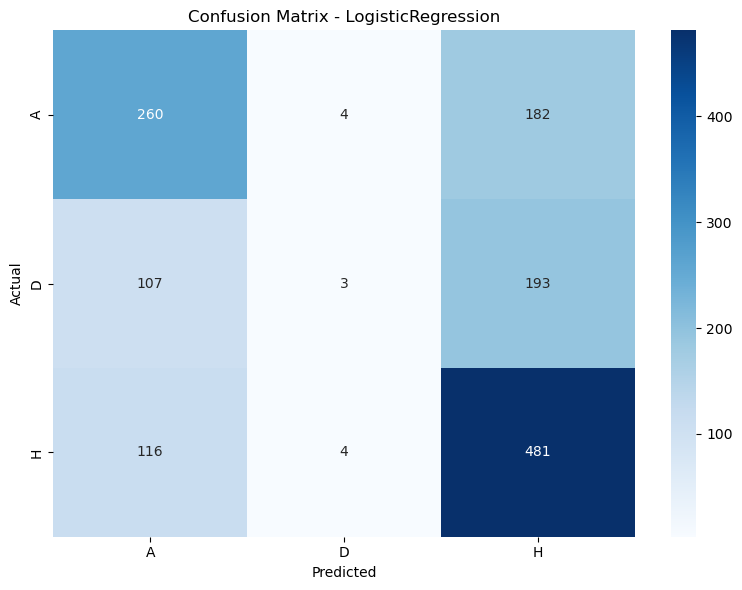

[INFO] Saved performance metrics to /Users/fitsumbahlebi/Desktop/repo2/PremierLeagueMatchPredictor/Images/model_performance_metrics_multiclass.png


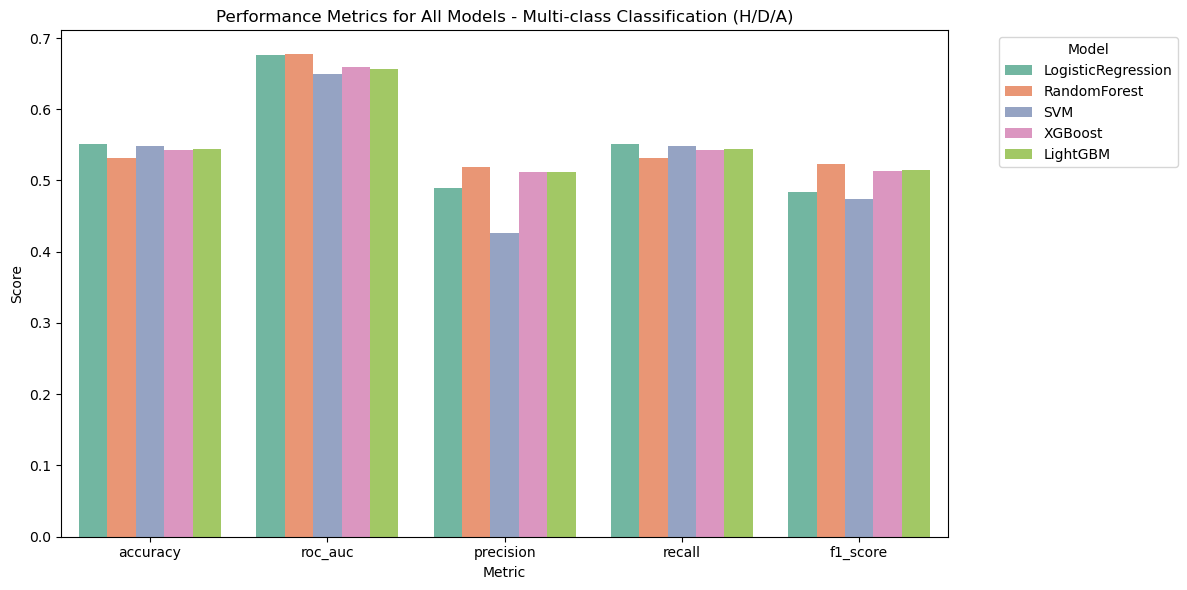


Final Model Comparison (multiclass):
                model  accuracy   roc_auc
1        RandomForest  0.531852  0.676980
0  LogisticRegression  0.551111  0.676818
3             XGBoost  0.542222  0.659741
4            LightGBM  0.544444  0.656203
2                 SVM  0.548148  0.649853
[INFO] Saved sorted results to /Users/fitsumbahlebi/Desktop/repo2/PremierLeagueMatchPredictor/Results/final_model_results_multiclass.csv
[INFO] Saved best multi-class model 'RandomForest' and label encoder

Running Binary Classification Model (H vs. Home loses)

[INFO] Using binary target (Home win vs. Home loses)
[INFO] Encoded classes: [0: Home loses, 1: Home wins]

[INFO] Using roc_auc for model evaluation

=== Tuning LogisticRegression ===
[INFO] Best params for LogisticRegression: {'clf__C': 0.1}

=== Tuning RandomForest ===
[INFO] Best params for RandomForest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

=== Tuning SVM ===
[INFO] Best params for SVM: {'clf__C': 0.1, 'clf__gamm

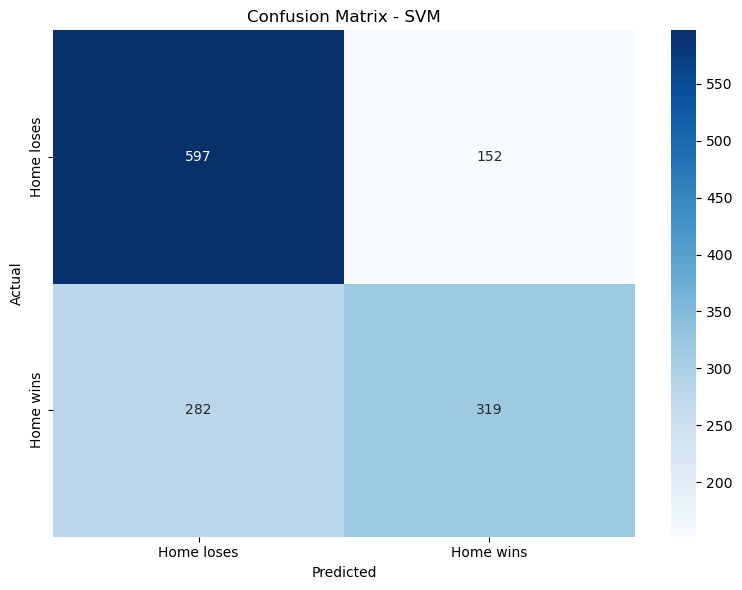

[INFO] Saved performance metrics to /Users/fitsumbahlebi/Desktop/repo2/PremierLeagueMatchPredictor/Images/model_performance_metrics_binary.png


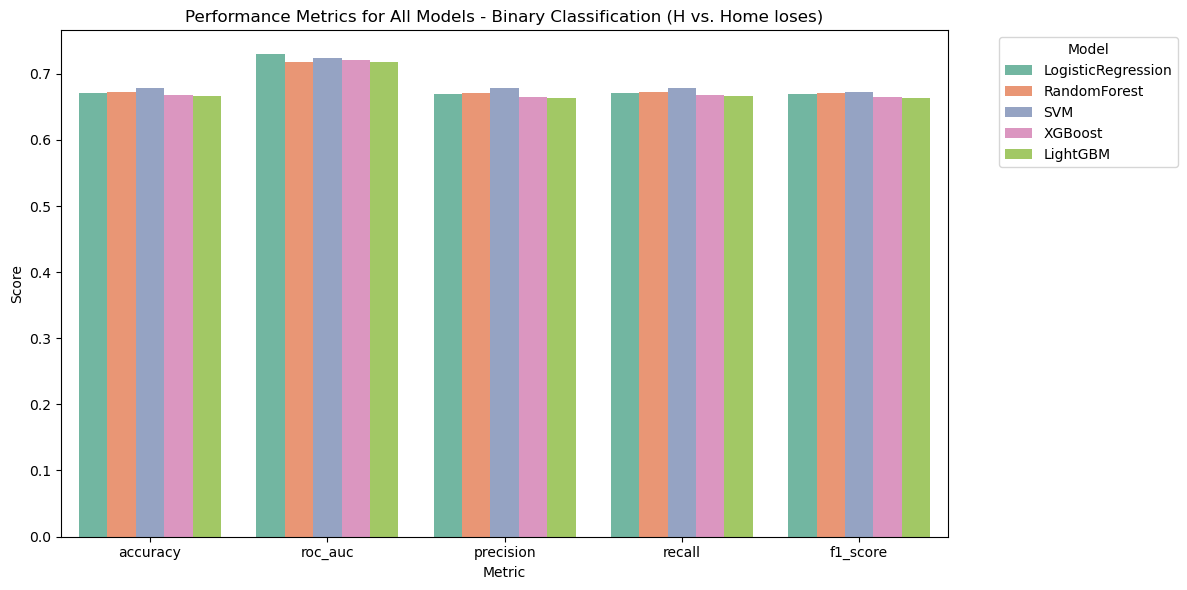


Final Model Comparison (binary):
                model  accuracy   roc_auc
0  LogisticRegression  0.670370  0.729290
2                 SVM  0.678519  0.723909
3             XGBoost  0.667407  0.720346
4            LightGBM  0.665926  0.718367
1        RandomForest  0.672593  0.718218
[INFO] Saved sorted results to /Users/fitsumbahlebi/Desktop/repo2/PremierLeagueMatchPredictor/Results/final_model_results_binary.csv
[INFO] Saved best binary model 'LogisticRegression' and label encoder

=== Comparison: Binary vs. Multiclass ===
                    Approach          Best Model  Accuracy  ROC AUC  F1 Score
0         Multiclass (H/D/A)        RandomForest  0.531852  0.67698  0.523422
1  Binary (H vs. Home loses)  LogisticRegression  0.670370  0.72929  0.669270
[INFO] Saved comparison plot to /Users/fitsumbahlebi/Desktop/repo2/PremierLeagueMatchPredictor/Images/binary_vs_multiclass_comparison.png


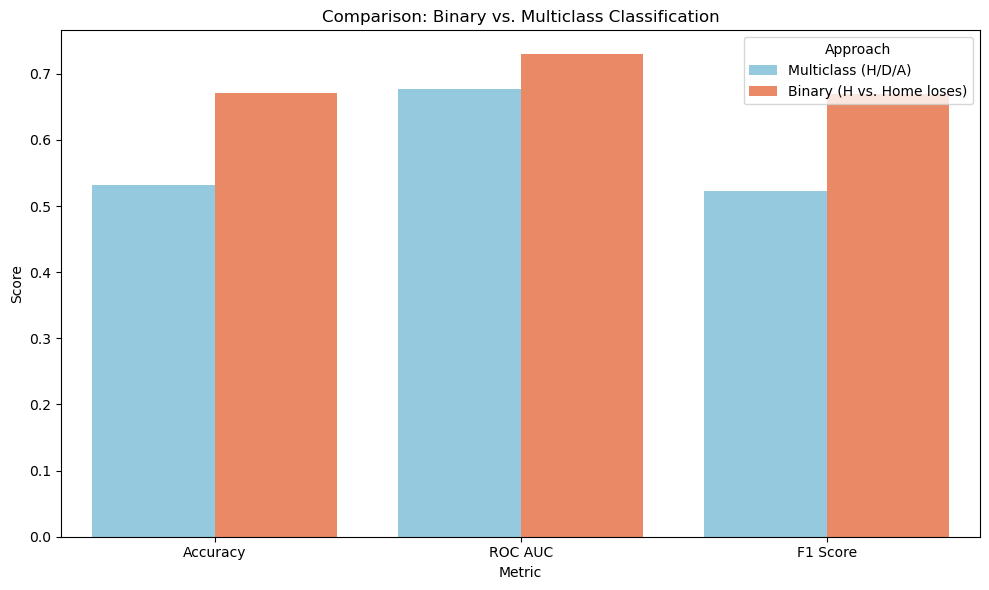


Best multi-class model: RandomForest
Best binary model: LogisticRegression


In [59]:
if __name__ == "__main__":
    csv_path = "/Users/fitsumbahlebi/Desktop/repo2/EPL/Data/Processed/epl_engineered_filtered.csv"
    
    # Run both approaches and save models
    results = run_epl_prediction(csv_path, run_original=True, run_binary=True, save_models=True)
    
    # Access results if needed for further analysis
    best_multiclass_model_name = results['multiclass']['results'].iloc[0]['model']
    best_binary_model_name = results['binary']['results'].iloc[0]['model']
    
    print(f"\nBest multi-class model: {best_multiclass_model_name}")
    print(f"Best binary model: {best_binary_model_name}")